# serial-comm: comunicación y registro de datos por puerto serial
Autor: Claudio Morales D.<br>
https://github.com/cmoralesd/serial-comm <br>
Otoño 2023<br>
<br>
Código base para establecer comunicación por puerto serial entre un dispositivo Arduino (o similar) y un script de Python, utilizando la librería **pyserial**, controlar entradas y salidas del módulo Arduino mediante valores numéricos intercambiados en formato de texto, registrar datos en un archivo CSV, procesar los datos utilizando las herramientas básicas de la librería **pandas** y obtener gráficos de los datos registrados utilizando **matplotlib.pyplot**.

Para comprender las características generales de la comunicación serial, consulte: https://hetpro-store.com/TUTORIALES/puerto-serial/

Los archivos para programación del módulo Arduino se encuentran en https://github.com/cmoralesd/serial-comm


In [1]:
# librerías requeridas
import serial  # librería pyserial, para comunicación con los puertos serial < pip install pyserial >
import time    # para el manejo de eventos de tiempo, nativa de Python
import pandas as pd  # para el manejo de archivos de datos < pip install pandas >
import matplotlib.pyplot as plt # para realizar gráficos < pip install matplotlib >


# funciones para enviar y recibir mensajes en formato de texto, codificado en UTF-8
# los mensajes utilizan como terminador un caracter de final de línea '\n'
def encode_send(ser, texto):
    enc = f'{texto}\n'.encode('UTF-8')
    ser.write(enc)

def decode_response(ser):
    message_from_serial = ser.readline()
    res = message_from_serial[:-1].decode()
    return res


### 1. Código base en esquema request-response

El esquema de comunicación utilizado es **maestro-esclavo** (master-slave) en modo **request-response** (requerimiento-respuesta): sólo un dispositivo puede iniciar la comunicación enviando un requerimiento y el otro dispositivo responde. 

En este caso, el script de Python siempre inicia la comunicación, con un mensaje de texto que contiene dos valores enteros separados por una coma (,). El dispositivo Arduino recibe el mensaje, lo procesa, y envía una respuesta.

El código utilizado en Arduino es: **serial-comm.ino**

In [9]:
# Esquema básico para request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
val_0 = 123
val_1 = 456
message_to_serial = str(val_0) + ',' + str(val_1)

# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')
print(f'recibido: {message_from_serial}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')


enviado: 123,456
recibido: Arduino OK
el puerto se ha cerrado correctamente


### 2. Enviando mensajes en forma cíclica

El código utilizado en Arduino es: **serial-comm.ino**

In [6]:
# Esquema básico para comunicarse por puerto serial en forma cíclica
# El código utilizado en Arduino es: serial-comm.ino

# inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms
time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 1. # en segundos


# inicia el ciclo de intercambio de datos
while time_elapsed < time_stop:
    # Preparamos el mensaje a ser transmitido
    val_0 = 0
    val_1 = 0
    message_to_serial = str(val_0) + ',' + str(val_1)

    # enviamos al puerto y esperamos la respuesta
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    # procesamos la respuesta
    print(f'enviado: {message_to_serial}')
    print(f'recibido: {message_from_serial}')

    #atualizar la medicion de timepo
    time_elapsed = time.perf_counter() - time_start
    print(f'recibido: {time_elapsed}')

# cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 0,0
recibido: Arduino OK
recibido: 0.5345586000000822
enviado: 0,0
recibido: 681;665
recibido: 0.5524406000000681
enviado: 0,0
recibido: 670;665
recibido: 0.5701277000000573
enviado: 0,0
recibido: 664;661
recibido: 0.5879524000000629
enviado: 0,0
recibido: 657;656
recibido: 0.605610200000001
enviado: 0,0
recibido: 650;649
recibido: 0.6233279000000493
enviado: 0,0
recibido: 646;644
recibido: 0.6410852000000204
enviado: 0,0
recibido: 642;640
recibido: 0.6587787000000844
enviado: 0,0
recibido: 641;638
recibido: 0.6765728999999965
enviado: 0,0
recibido: 640;637
recibido: 0.6942923000000292
enviado: 0,0
recibido: 640;637
recibido: 0.7121131000000105
enviado: 0,0
recibido: 637;635
recibido: 0.7298500000000558
enviado: 0,0
recibido: 633;631
recibido: 0.7479607000000215
enviado: 0,0
recibido: 628;626
recibido: 0.7657700000000887
enviado: 0,0
recibido: 621;620
recibido: 0.7834202000000232
enviado: 0,0
recibido: 616;615
recibido: 0.8010839000000942
enviado: 0,0
recibido: 612;611
recibid

### 2. Controlando pines I/O en el dispositivo Arduino

El código utilizado en Arduino es: **serial-control.ino**

In [12]:
# Esquema básico para control de pines I/O en modo request-response
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicación y espera a que esté listo
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Preparamos el mensaje a ser transmitido
led_verde = 0    # 0 = apagado, otro valor = encendido
led_rojo = 0     # nivel PWM entre 0 y 255
message_to_serial = str(led_verde) + ',' + str(led_rojo)

# 3. Enviamos al puerto y esperamos la respuesta
encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)

encode_send(serialport, message_to_serial)
message_from_serial = decode_response(serialport)
# 4. Procesamos la respuesta
print(f'enviado: {message_to_serial}')

data = message_from_serial.split(';')
val_x = int(data[0])
val_y = int(data[1])
print(f'val_x = {val_x}')
print(f'val_y = {val_y}')

# 5. Cierra el puerto serial
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 0,0
val_x = 511
val_y = 506
el puerto se ha cerrado correctamente


In [14]:
serialport.close()

### 4. Registrando datos recibidos desde el puerto serial

El código utilizado en Arduino es: **serial-control.ino**

In [13]:
# Registro de transacciones vía puerto serial
# El código utilizado en Arduino es: serial-comm.ino

# 1. Inicializa el puerto de comunicaciones
serialport = serial.Serial('COM5', 9600)
time.sleep(0.1)   # tiempo de espera recomendado: 100 ms

# 2. Inicializa el archivo de registro de datos
filename = 'dataset-' + time.strftime('%d-%m-%y-%H%M%S') + '.csv'
with open(filename, 'w') as file:
    file.write('tiempo,led_verde,led_rojo,val_x,val_y\n')

# 3. Registra las transacciones durante un periodo de tiempo especificado
time_start = time.perf_counter()
time_elapsed = time.perf_counter() - time_start
time_stop = 5. # en segundo

while time_elapsed < time_stop:
    led_verde = 1    # 0 = apagado, otro valor = encendido
    led_rojo = time_elapsed/time_stop * 255     # nivel PWM entre 0 y 255
    message_to_serial = str(led_verde) + ',' + str(led_rojo)

    #Enviamos al puerto y esperamos la respuestas
    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    encode_send(serialport, message_to_serial)
    message_from_serial = decode_response(serialport)

    #procesamos el mensaje recibido
    data = message_from_serial.split(';')
    val_x = int(data[0])
    val_y = int(data[1])

    print(f'enviado: {message_to_serial}')
    print(f'enviado: {message_from_serial}')
    
    with open(filename, 'a') as file:
        file.write(str(time_elapsed) + ',' + str(led_verde) + ',' +str(led_rojo) + ',' +str(val_x) + ',' +str(val_y) + '\n')

    time_elapsed = time.perf_counter() - time_start
# 4. Cierra el puerto de comunicaciones
serialport.close()
print('el puerto se ha cerrado correctamente')

enviado: 1,0.002320499997040315
enviado: 514;508
enviado: 1,29.39659889999143
enviado: 512;507
enviado: 1,32.9918846999974
enviado: 513;508
enviado: 1,36.49044899999535
enviado: 513;507
enviado: 1,40.107465899996896
enviado: 513;507
enviado: 1,43.798958099996526
enviado: 513;507
enviado: 1,47.49244949999343
enviado: 512;507
enviado: 1,51.13266119999207
enviado: 512;507
enviado: 1,54.734546399991814
enviado: 513;507
enviado: 1,58.43023080000057
enviado: 513;507
enviado: 1,62.030208599994694
enviado: 513;507
enviado: 1,65.7166976999913
enviado: 512;507
enviado: 1,69.1872884999932
enviado: 513;507
enviado: 1,72.71435159999805
enviado: 513;507
enviado: 1,76.3104890999955
enviado: 512;507
enviado: 1,79.77366449999408
enviado: 512;507
enviado: 1,83.36636460000136
enviado: 512;507
enviado: 1,86.95097100000066
enviado: 512;507
enviado: 1,90.54298769999923
enviado: 512;507
enviado: 1,94.11548159999143
enviado: 512;507
enviado: 1,97.71503609999763
enviado: 512;507
enviado: 1,101.3148354000009
en

In [21]:
serialport.close()

In [14]:
df = pd.read_csv(filename)
df

,tiempo,led_verde,led_rojo,val_x,val_y
0,0.000045,1,0.002320,514,508
1,0.576404,1,29.396599,512,507
2,0.646900,1,32.991885,513,508
3,0.715499,1,36.490449,513,507
4,0.786421,1,40.107466,513,507
...,...,...,...,...,...
59,4.712503,1,240.337628,1023,212
60,4.787013,1,244.137688,0,941
61,4.857822,1,247.748897,0,941
62,4.911650,1,250.494155,511,506


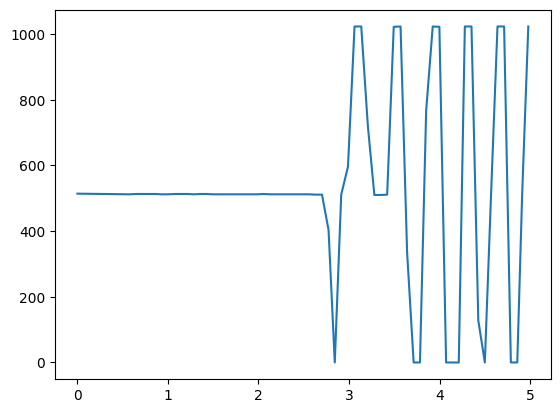

In [15]:
x = df['tiempo'].tolist()
y = df['val_x'].tolist()

ax = plt.figure().add_subplot()
ax.plot(x , y)
plt.show()